# RIBBIT Pulse Rate model demonstration
RIBBIT (Repeat-Interval Based Bioacoustic Identification Tool) is a tool for detecting vocalizations that have a repeating structure.

This tool is useful for detecting vocalizations of frogs, toads, and other animals that produce vocalizations with a periodic structure. In this notebook, we demonstrate how to select model parameters for the Great Plains Toad, then run the model on data to detect vocalizations.

RIBBIT was introduced in the 2020 poster "Automatic Detection of Pulsed Vocalizations"

This notebook demonstrates how to use the RIBBIT tool implemented in opensoundscape as `opensoundscape.ribbit.ribbit()`

For help instaling OpenSoundscape, see the [documentation](https://opensoundscape.org)

### import packages

In [1]:
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt

#local imports from opensoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.ribbit import ribbit

# #for big visuals
plt.rcParams['figure.figsize']=[15,8] 

/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


#### download example audio

first, let's download some example audio to work with.

You can run the cell below, **OR** visit this link to downlaod the data (whichever you find easier):

https://pitt.box.com/shared/static/0xclmulc4gy0obewtzbzyfnsczwgr9we.zip

If you download using the link above, first un-zip the folder (double-click on mac or right-click -> extract all on Windows). Then, move the `great_plains_toad_dataset` folder to the same location on your computer as this notebook. Then you can skip this cell:

In [2]:
import os
#download files from box.com to the current directory
os.system(f"curl -L https://pitt.box.com/shared/static/9mrxib85y1jmf1ybbjvbr0tv171iekvy.gz -o ./great_plains_toad_dataset.tar.gz")# | tar -xz -f")
os.system(f"tar -xz -f great_plains_toad_dataset.tar.gz")

#this will print `0` if everything went correctly. If it prints 256 or another number, something is wrong (try downloading from the link above)

0

now, you should have a folder in the same location as this notebook called `great_plains_toad_dataset`

if you had trouble accessing the data, you can try using your own audio files - just put them in a folder called `great_plains_toad_dataset` in the same location as this notebook, and this notebook will load whatever is in that folder

### load an audio file with a Great Plains Toad vocalization and and create a spectrogram

In [3]:
audio_path = np.sort(glob('./great_plains_toad_dataset/*'))[0]

#load the audio file into an OpenSoundscape Audio object
audio = Audio.from_file(audio_path)

#trim the audio to the time from 0-3 seconds for a closer look
audio = audio.trim(0,3)

#create a Spectrogram object
spectrogram = Spectrogram.from_audio(audio)

### show the Great Plains Toad spectrogram as an image
a spectrogram is a visual representation of audio with frequency on the vertical axis, time on the horizontal axis, and intensity represented by the color of the pixels

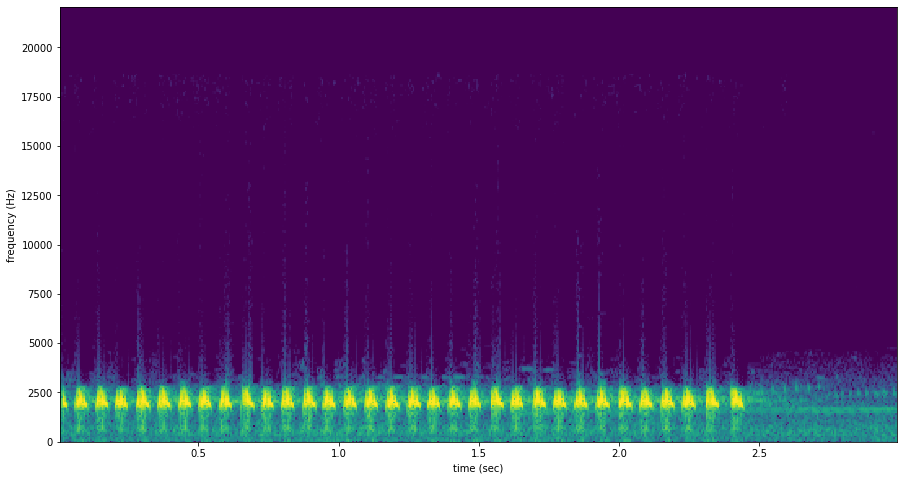

In [4]:
spectrogram.plot()

## select model parameters

RIBBIT requires the user to select a set of parameters that describe the target vocalization. Here is some detailed advice on how to use these parameters.

**Signal Band:** The signal band is the frequency range where RIBBIT looks for the target species. Based on the spectrogram above, we can see that the Great Plains Toad vocalization has the strongest energy around 2000-2500 Hz, so we will specify `signal_band = [2000,2500]`. It is best to pick a narrow signal band if possible, so that the model focuses on a specific part of the spectrogram and has less potential to include erronious sounds. 

**Noise Bands:** Optionally, users can specify other frequency ranges called noise bands. Sounds in the `noise_bands` are _subtracted_ from the `signal_band`. Noise bands help the model filter out erronious sounds from the recordings, which could include confusion species, background noise, and popping/clicking of the microphone due to rain, wind, or digital errors. It's usually good to include one noise band for very low frequencies -- this specifically eliminates popping and clicking from being registered as a vocalization. It's also good to specify noise bands that target confusion species. Another approach is to specify two narrow `noise_bands` that are directly above and below the `signal_band`. 

**Pulse Rate Range:** This parameters specifies the minimum and maximum pulse rate (the number of pulses per second, also known as pulse repetition rate) RIBBIT should look for to find the focal species. Looking at the spectrogram above, we can see that the pulse rate of this Great Plains Toad vocalization is about 15 pulses per second. By looking at other vocalizations in different environmental conditions, we notice that the pulse rate can be as slow as 10 pulses per second or as fast as 20. So, we choose `pulse_rate_range = [10, 20]` meaning that RIBBIT should look for pulses no slower than 10 pulses per second and no faster than 20 pulses per second. 

**Window Length:** This parameter tells the algorithm how many seconds of audio to analyze at one time. Generally, you should choose a `window_length` that is similar to the length of the target species vocalization, or a little bit longer. For very slowly pulsing vocalizations, choose a longer window so that at least 5 pulses can occur in one window (0.5 pulses per second -> 10 second window). Typical values for `window_length` are 1 to 10 seconds. Keep in mind that The Great Plains Toad has a vocalization that continues on for many seconds (or minutes!) so we chose a 2-second window which will include plenty of pulses. 

**Plot:** We can choose to show the power spectrum of pulse repetition rate for each window by setting `plot=True`. The default is not to show these plots (`plot=False`).

In [5]:
# minimum and maximum rate of pulsing (pulses per second) to search for
pulse_rate_range = [10,20] 

# look for a vocalization in the range of 1000-2000 Hz 
signal_band = [2000,2500] 

# subtract the amplitude signal from these frequency ranges
noise_bands = [ [0,200], [10000,10100]] 

#divides the signal into segments this many seconds long, analyzes each independently
window_length = 2 #(seconds) 

#if True, it will show the power spectrum plot for each audio segment 
show_plots = True 

## search for pulsing vocalizations with `ribbit()` 

This function takes the parameters we chose above as arguments, performs the analysis, and returns two arrays:
 - **scores:** the pulse rate score for each window
 - **times:** the start time in seconds of each window
 
The scores output by the function may be very low or very high. They do not represent a "confidence" or "probability" from 0 to 1. Instead, the relative values of scores on a set of files should be considered: when RIBBIT detects the target species, the scores will be significantly higher than when the species is not detected. 

#### analyzing one file
The file `gpt0.wav` has a Great Plains Toad vocalizing only at the beginning. Let's analyze the file with RIBBIT and look at the scores versus time.

spectrogram of 10 second file with Great Plains Toad at the beginning


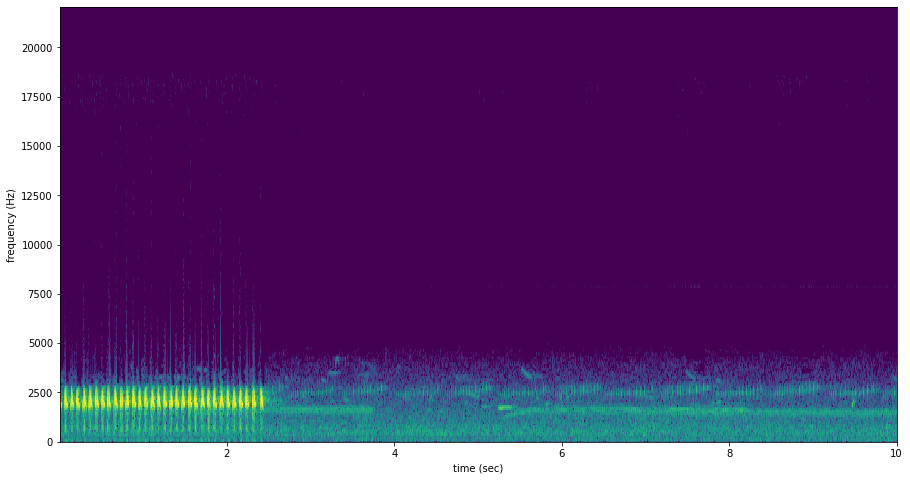

Text(0.5, 1.0, 'RIBBIT scores for 10 second file with Great Plains Toad at the beginning')

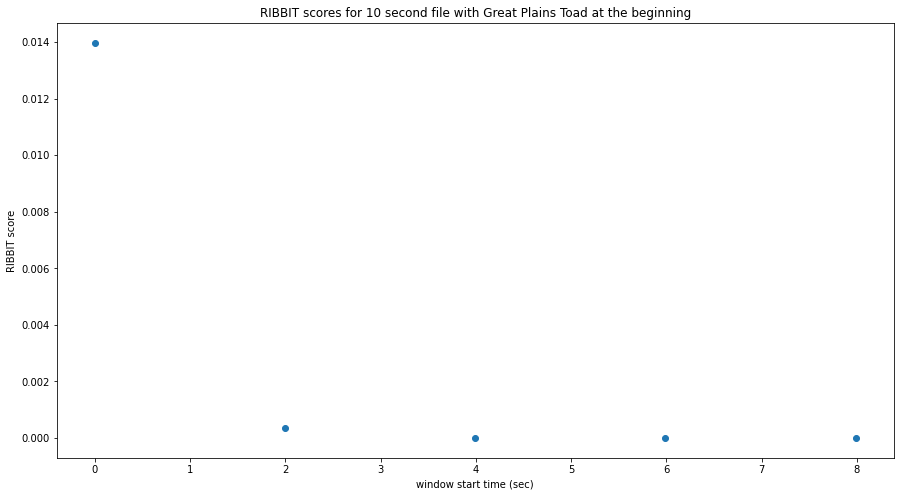

In [8]:
#get the audio file path
audio_path = np.sort(glob('./great_plains_toad_dataset/*'))[0]

#make the spectrogram
spec = Spectrogram.from_audio(audio.from_file(audio_path))

#run RIBBIT
scores, times =  ribbit(
                    spec,
                    pulse_rate_range=pulse_rate_range,
                    signal_band=signal_band,
                    window_len=window_length,
                    noise_bands=noise_bands,
                    plot=False)


#show the spectrogram
print('spectrogram of 10 second file with Great Plains Toad at the beginning')
spec.plot()

# plot the score vs time of each window
plt.scatter(times,scores)
plt.xlabel('window start time (sec)')
plt.ylabel('RIBBIT score')
plt.title('RIBBIT scores for 10 second file with Great Plains Toad at the beginning')

as we hoped, RIBBIT outputs a high score during the vocalization (the window from 0-2 seconds) and a low score when the frog is not vocalizing

#### analyzing a set of files

In [12]:
# set up a dataframe for storing files' scores and labels
df = pd.DataFrame(index = glob('./great_plains_toad_dataset/*'),columns=['score','label'])

# label is 1 if the file contains a Great Plains Toad vocalization, and 0 if it does not
df['label'] = [1 if 'gpt' in f else 0 for f in df.index] 

# calculate RIBBIT scores
for path in df.index:
    
    #make the spectrogram
    spec = Spectrogram.from_audio(audio.from_file(path))

    #run RIBBIT
    scores, times =  ribbit(
                        spec,
                        pulse_rate_range=pulse_rate_range,
                        signal_band=signal_band,
                        window_len=window_length,
                        noise_bands=noise_bands,
                        plot=False)
    
    # use the maximum RIBBIT score from any window as the score for this file
    # multiply the score by 10,000 to make it easier to read
    df.at[path,'score'] = max(scores) * 10000

print("Files sorted by score, from highest to lowest:")
df.sort_values(by='score',ascending=False)

Files sorted by score, from highest to lowest:


,score,label
./great_plains_toad_dataset/gpt0.mp3,139.765,1
./great_plains_toad_dataset/gpt3.mp3,13.8338,1
./great_plains_toad_dataset/gpt2.mp3,8.25766,1
./great_plains_toad_dataset/gpt1.mp3,6.1136,1
./great_plains_toad_dataset/negative3.mp3,2.34044,0
./great_plains_toad_dataset/negative2.mp3,1.73015,0
./great_plains_toad_dataset/negative4.mp3,1.56953,0
./great_plains_toad_dataset/negative1.mp3,1.21802,0
./great_plains_toad_dataset/negative9.mp3,1.13301,0
./great_plains_toad_dataset/negative8.mp3,1.08165,0


So, how good is RIBBIT at finding the Great Plains Toad?

We can see that the scores for all of the files with Great Plains Toad (gpt) score above 6 except `gpt4.mp3` (which contains only a very quiet and distant vocalization). All files that do not contain the Great Plains Toad score less than 2.5. So, RIBBIT is doing a good job separating Great Plains Toads vocalizations from other sounds! 

Notably, noisy files like `pops1.mp3` score low even though they have lots of periodic energy - our `noise_bands` sucessfully rejected these files. Without using `noise_bands`, files like these would receive very high scores. Also, some birds in "negatives" files  that have periodic calls around the same pulsre rate as the Great Plains Toad received low scores. This is also a result of choosing a tight `signal_band` and strategic `noise_bands`. You can try adjusting or eliminating these bands to see their effect on the audio. 

(HINT: elimintating the `noise_bands` will result in high scores for the "pops" files)

## detail view
Now, lets look at one 10 second file and tell ribbit to plot the power spectral density for each window (`plot=True`). This way, we can see if peaks are emerging at the expected pulse rates. Since our `window_length` is 2 seconds, each of these plots represents 2 seconds of audio. The vertical lines on the power spectral density represent the lower and upper `pulse_rate_range` limits. 

In the file `gpt0.mp3`, the Great Plains Toad vocalizes for a couple seconds at the beginning, then stops. We expect to see a peak in the power spectral density at 15 pulses/sec in the first 2 second window, and maybe a bit in the second, but not later in the audio. 

window: 0.0000 sec to 1.9969 sec
peak freq: 13.4583


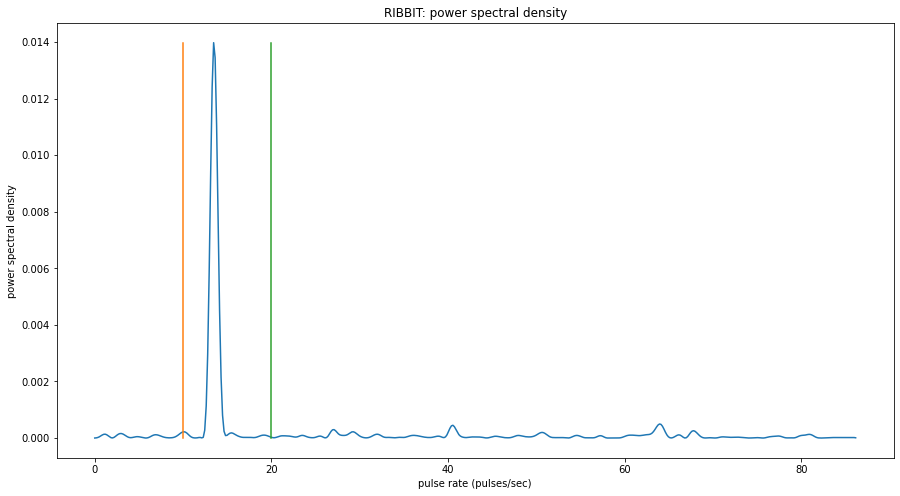

window: 1.9969 sec to 3.9938 sec
peak freq: 0.6729


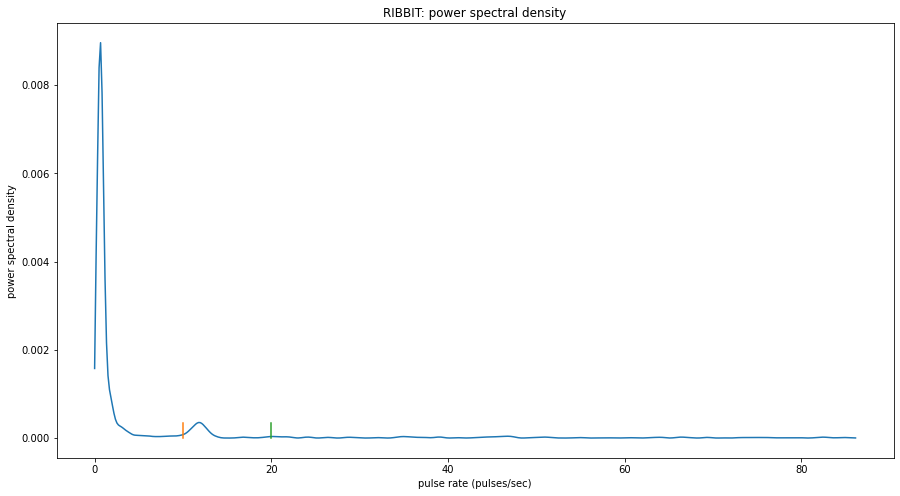

window: 3.9938 sec to 5.9907 sec
peak freq: 57.0293


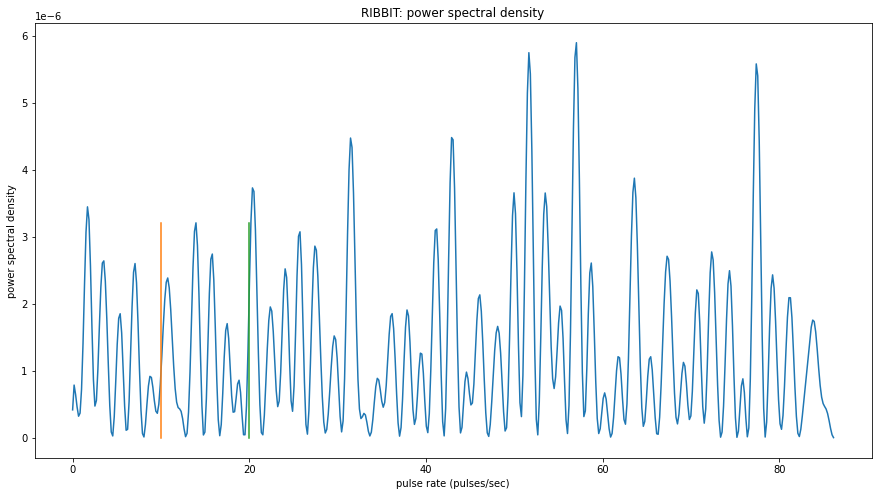

window: 5.9907 sec to 7.9877 sec
peak freq: 23.7202


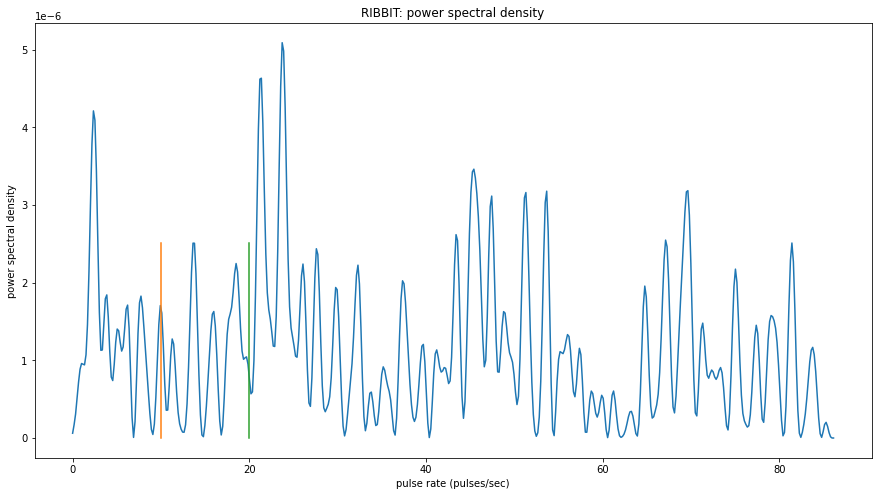

In [45]:
#create a spectrogram from the file, like above:
# 1. get audio file path
audio_path = np.sort(glob('./great_plains_toad_dataset/*'))[0]
# 2. make audio object and trim (this time 0-10 seconds)
audio = Audio.from_file(audio_path).trim(0,10)
# 3. make spectrogram
spectrogram = Spectrogram.from_audio(audio)

scores, times =  ribbit(
                        spectrogram,
                        pulse_rate_range=pulse_rate_range,
                        signal_band=signal_band,
                        window_len=window_length,
                        noise_bands=noise_bands,
                        plot=show_plots)


# Time to experiment

Now that you know the basics of how to use RIBBIT, you can try using it on your own data. We recommend spending some time looking at different recordings of your focal species before choosing parameters. Experiment with the noise bands and window length, and get in touch if you have questions!

Sam's email: sam . lapp [at] pitt.edu

#### clean up
this cell will delete the folder `great_plains_toad_dataset`. Only run it if you wish delete that folder and the example audio inside it. 

In [17]:
os.system('rm -r ./great_plains_toad_dataset/')
os.system('rm ./great_plains_toad_dataset.tar.gz')

0